<h2>Importing Libraries and Modules</h2>

In [0]:
# !pip install geopy
# !pip install scikit-learn==0.22.1 --user
# !pip install imblearn --user
# !pip install xgboost

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np

from geopy.distance import great_circle
import datetime
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, RandomizedSearchCV

from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


<h2>Loading the Datasets</h2>

In [2]:
## Loading the Datasets
train = pd.read_csv('../../data/weka_processed/train_pro.csv')
test = pd.read_csv('../../data/test.csv')

# ## Loading the Datasets
# train = pd.read_csv('drive/My Drive/ML/data/weka_processed/train_pro.csv')
# test = pd.read_csv('drive/My Drive/ML/data/test.csv')


<h2>Basic Intuition on the Data</h2>

In [3]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834,56,0,64,'11/1/2019 0:20','11/1/2019 0:34',6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791,47,0,134,'11/1/2019 0:56','11/1/2019 1:09',6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087,80,0,61,'11/1/2019 1:08','11/1/2019 1:26',6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598,271,15.6638,68,'11/1/2019 2:27','11/1/2019 2:37',6.92570,79.8895,6.92748,79.8971,82.3,correct
4,189128020,?,?,?,?,?,'11/1/2019 3:34','11/1/2019 3:51',6.87441,79.8615,6.84478,79.9290,358.39,correct


In [4]:
test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15327 entries, 0 to 15326
Data columns (total 14 columns):
tripid                       15327 non-null int64
additional_fare              15327 non-null object
duration                     15327 non-null object
meter_waiting                15327 non-null object
meter_waiting_fare           15327 non-null object
meter_waiting_till_pickup    15327 non-null object
pickup_time                  15327 non-null object
drop_time                    15327 non-null object
pick_lat                     15327 non-null float64
pick_lon                     15327 non-null float64
drop_lat                     15327 non-null float64
drop_lon                     15327 non-null float64
fare                         15327 non-null object
label                        15327 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 1.6+ MB


In [6]:
train.shape

(15327, 14)

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 0 to 8575
Data columns (total 13 columns):
tripid                       8576 non-null int64
additional_fare              8576 non-null float64
duration                     8576 non-null int64
meter_waiting                8576 non-null int64
meter_waiting_fare           8576 non-null float64
meter_waiting_till_pickup    8576 non-null int64
pickup_time                  8576 non-null object
drop_time                    8576 non-null object
pick_lat                     8576 non-null float64
pick_lon                     8576 non-null float64
drop_lat                     8576 non-null float64
drop_lon                     8576 non-null float64
fare                         8576 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 871.1+ KB


In [8]:
test.shape

(8576, 13)

<h2>Cleaning the Data</h2>

In [9]:
## cleaning weka added unnecessary values

train = train.replace({'?': np.nan})


In [10]:
## converting label values into 0,1 instead of correct, incorrect

train.label = train.label.map(dict(correct=1, incorrect=0))

In [11]:
## check for missing values in the dataset

# train.isna().head()
train.isna().sum()

tripid                         0
additional_fare              196
duration                     196
meter_waiting                196
meter_waiting_fare           196
meter_waiting_till_pickup    196
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         133
label                          0
dtype: int64

In [12]:
test.isna().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
dtype: int64

In [13]:
## fill missing values by mean of the column

# train.fillna(train.mean(), inplace=True)

# imputer = IterativeImputer(max_iter=10, random_state=42)
# imputer.fit(train.iloc[:,[1,2,3,4,5,12]])
# train.iloc[:,[1,2,3,4,5,12]] = imputer.transform(train.iloc[:,[1,2,3,4,5,12]])


imputer = KNNImputer(n_neighbors=5, weights='uniform')
train.iloc[:,[1,2,3,4,5,12]] = imputer.fit_transform(train.iloc[:,[1,2,3,4,5,12]])


In [14]:
train.isna().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
dtype: int64

<h2>Basic Feature Engineering</h2>

In [15]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)


<h4>Clustering Based Feature Column</h4>

In [16]:
dbscan = DBSCAN(eps=0.3, min_samples=5)

cluster_pred = dbscan.fit_predict(dataset.drop(labels=['tripid', 'label', 'pickup_time', 'drop_time'], axis=1))

# cluster_pred = np.where(cluster_pred == -1, 10, cluster_pred)


In [17]:
unique1, count1 = np.unique(cluster_pred, return_counts=True)
{k:v for (k,v) in zip(unique1, count1)}


{-1: 23774, 0: 17, 1: 112}

In [18]:
dataset['cluster'] = cluster_pred


<h4>Location Cluster Feature Column</h4>

In [19]:
pick_coord_dt = dataset.loc[:, ['pick_lat', 'pick_lon']]
drop_coord_dt = dataset.loc[:, ['drop_lat', 'drop_lon']]


In [20]:
dbscan = DBSCAN(eps=0.01, min_samples=5)
pick_labels = dbscan.fit_predict(pick_coord_dt)

dbscan = DBSCAN(eps=0.01, min_samples=5)
drop_labels = dbscan.fit_predict(drop_coord_dt)


In [21]:
# pick_labels = np.where(pick_labels == -1, 50, pick_labels)
# drop_labels = np.where(drop_labels == -1, 50, drop_labels)


In [22]:
unique1, count1 = np.unique(pick_labels, return_counts=True)
{k:v for (k,v) in zip(unique1, count1)}


{-1: 213,
 0: 20205,
 1: 2760,
 2: 88,
 3: 37,
 4: 76,
 5: 5,
 6: 22,
 7: 12,
 8: 8,
 9: 20,
 10: 12,
 11: 27,
 12: 7,
 13: 6,
 14: 28,
 15: 8,
 16: 14,
 17: 9,
 18: 5,
 19: 5,
 20: 6,
 21: 7,
 22: 5,
 23: 159,
 24: 149,
 25: 5,
 26: 5}

In [23]:
unique1, count1 = np.unique(drop_labels, return_counts=True)
{k:v for (k,v) in zip(unique1, count1)}


{-1: 351,
 0: 20147,
 1: 2738,
 2: 75,
 3: 25,
 4: 10,
 5: 62,
 6: 25,
 7: 8,
 8: 21,
 9: 17,
 10: 6,
 11: 10,
 12: 6,
 13: 17,
 14: 17,
 15: 13,
 16: 13,
 17: 5,
 18: 9,
 19: 5,
 20: 5,
 21: 5,
 22: 5,
 23: 6,
 24: 5,
 25: 6,
 26: 4,
 27: 3,
 28: 132,
 29: 146,
 30: 5,
 31: 1}

In [24]:
dataset['pick_cluster'] = pick_labels
dataset['drop_cluster'] = drop_labels


<h2>Advanced Feature Engineering</h2>

In [33]:
## new feature columns
trip_fare = []
trip_duration = []
trip_distance = []

distance_to_duration = []
distance_to_duration_min_meter_waiting = []
fare_to_duration = []
fare_to_distance = []
waiting_fare_to_waiting_duration = []
duration_min_waiting_to_fare = []
additional_fare_to_distance = []
fare_min_waiting_fare_to_duration_min_meter_waiting = []
waiting_duration_to_duration = []
additional_fare_to_fare = []

duration_from_time = []
duration_error = []

## j48 rules
duration_bucket = []    ## 50
fare_bucket = []        ## 50

## dataset inspection rules
fare_waiting_gap = []
additional_fare_greater_than_250 = []
is_duration_zero = []

# time based new features
fare_month = []
fare_hour = []
is_midnight = []
is_weekend = []


In [34]:
## iterate through each row in the dataset
for row in dataset.itertuples():
    fare = float(row.fare)
    additional_fare = float(row.additional_fare)
    meter_waiting_fare = float(row.meter_waiting_fare)
    
    meter_waiting = row.meter_waiting
    meter_waiting_till_pickup = row.meter_waiting_till_pickup
    duration = row.duration
    
    pick_lat = row.pick_lat
    pick_lon = row.pick_lon
    drop_lat = row.drop_lat
    drop_lon = row.drop_lon
    
    pickup_time = row.pickup_time.replace('\'', '')
    drop_time = row.drop_time.replace('\'', '')
    pickup_time = pickup_time.split('/')
    drop_time = drop_time.split('/')
    
    # fare bucket
    fare_bucket.append(int(math.ceil(fare / 50)))
    
    # total fare for the trip
    cur_trip_fare = fare - (additional_fare + meter_waiting_fare)
    trip_fare.append(cur_trip_fare)
    
    # trip duration
    cur_trip_duration = duration - meter_waiting - meter_waiting_till_pickup
    trip_duration.append(cur_trip_duration)
    duration_bucket.append(int(math.ceil(cur_trip_duration / 50)))
    
    if(duration != 0):
        is_duration_zero.append(0)
    else:
        is_duration_zero.append(1)
    
    # trip distance
    cur_trip_distance = float(great_circle((drop_lat, drop_lon),(pick_lat, pick_lon)).kilometers)
    trip_distance.append(cur_trip_distance)
    
    # trip distance to duration
    try:
        cur_dist_to_dur = cur_trip_distance / cur_trip_duration
    except ZeroDivisionError:
        cur_dist_to_dur  = 0
    distance_to_duration.append(cur_dist_to_dur)
    
    # trip distance to (duration - meter_waiting_duration)
    try:
        cur_temp = cur_trip_distance / (duration - meter_waiting)
    except ZeroDivisionError:
        cur_temp = 0
    distance_to_duration_min_meter_waiting.append(cur_temp)
    
    # trip fare to trip duration
    try:
        cur_fare_to_duration = cur_trip_fare / cur_trip_duration
    except ZeroDivisionError:
        cur_fare_to_duration  = 0
    fare_to_duration.append(cur_fare_to_duration)
    
    # trip fare to trip distance
    try:
        cur_fare_to_distance = cur_trip_fare / cur_trip_distance
    except ZeroDivisionError:
        cur_fare_to_distance  = 0
    fare_to_distance.append(cur_fare_to_distance)
    
    # trip waiting fare to waiting duration
    try:
        cur_waiting_fare_to_waiting_dur = meter_waiting_fare / meter_waiting
    except ZeroDivisionError:
        cur_waiting_fare_to_waiting_dur  = 0
    waiting_fare_to_waiting_duration.append(cur_waiting_fare_to_waiting_dur)
    
    # (trip_duration - waiting_duration) to trip_fare
    try:
        cur_temp = (duration - meter_waiting) / fare
    except ZeroDivisionError:
        cur_temp = 0
    duration_min_waiting_to_fare.append(cur_temp)
    
    # additional_fare to distance
    try:
        cur_additional_fare_to_distance = additional_fare / cur_trip_distance
    except ZeroDivisionError:
        cur_additional_fare_to_distance = 0
    additional_fare_to_distance.append(cur_additional_fare_to_distance)
    
    # (fare - waiting_fare) to (duration - meter_waiting_duration)
    try:
        cur_temp = (fare - meter_waiting_fare) / (duration - meter_waiting)
    except ZeroDivisionError:
        cur_temp = 0
    fare_min_waiting_fare_to_duration_min_meter_waiting.append(cur_temp)
    
    # waiting_duration to duration
    try:
        cur_waiting_duration_to_duration = meter_waiting / duration
    except ZeroDivisionError:
        cur_waiting_duration_to_duration = 0
    waiting_duration_to_duration.append(cur_waiting_duration_to_duration)
    
    # additional_fare to fare
    try:
        cur_additional_fare_to_fare = additional_fare / fare
    except ZeroDivisionError:
        cur_additional_fare_to_fare = 0
    additional_fare_to_fare.append(cur_additional_fare_to_fare)
    
    # trip fare to waiting fare
    try:
        cur_fare_waiting_gap = (fare - meter_waiting_fare) / fare
    except ZeroDivisionError:
        cur_fare_waiting_gap  = 0
    fare_waiting_gap.append(cur_fare_waiting_gap)
    
    # additional fare greater than 250
    if(additional_fare > 250):
        additional_fare_greater_than_250.append(1)
    else:
        additional_fare_greater_than_250.append(0)
    
    # time duration
    # pickup time
    month, day, y_hm = int(pickup_time[0]), int(pickup_time[1]), pickup_time[2].split(' ')
    year, h_m = int(y_hm[0]), y_hm[1].split(':')
    hour, minute = int(h_m[0]), int(h_m[1])
    pickup_time = datetime.datetime(year, month, day, hour, minute)

    fare_month.append(month)
    fare_hour.append(hour)

    if 0 <= hour <= 5:
        is_midnight.append(1)
    else:
        is_midnight.append(0)
    
    weekday = pickup_time.weekday()
    if 0 <= weekday <= 4:
        is_weekend.append(1)
    else:
        is_weekend.append(0)
    
    # drop time
    month, day, y_hm = int(drop_time[0]), int(drop_time[1]), drop_time[2].split(' ')
    year, h_m = int(y_hm[0]), y_hm[1].split(':')
    hour, minute = int(h_m[0]), int(h_m[1])
    drop_time = datetime.datetime(year, month, day, hour, minute)
    
    # duration
    cur_duration_from_time = (drop_time - pickup_time).seconds
    duration_from_time.append(cur_duration_from_time)
    duration_error.append(cur_duration_from_time - duration)


In [35]:
## append new columns to dataset
dataset['trip_fare'] = trip_fare
dataset['distance_to_duration_min_meter_waiting'] = distance_to_duration_min_meter_waiting
dataset['trip_duration'] = trip_duration
dataset['trip_distance'] = trip_distance
dataset['distance_to_duration'] = distance_to_duration
dataset['fare_to_duration'] = fare_to_duration
dataset['fare_to_distance'] = fare_to_distance
dataset['waiting_fare_to_waiting_duration'] = waiting_fare_to_waiting_duration
dataset['duration_min_waiting_to_fare'] = duration_min_waiting_to_fare
dataset['additional_fare_to_distance'] = additional_fare_to_distance
dataset['fare_min_waiting_fare_to_duration_min_meter_waiting'] = fare_min_waiting_fare_to_duration_min_meter_waiting
dataset['waiting_duration_to_duration'] = waiting_duration_to_duration
dataset['additional_fare_to_fare'] = additional_fare_to_fare
dataset['duration_from_time'] = duration_from_time
dataset['duration_error'] = duration_error
dataset['duration_bucket'] = duration_bucket
dataset['fare_bucket'] = fare_bucket

dataset['fare_waiting_gap'] = fare_waiting_gap
dataset['additional_fare_greater_than_250'] = additional_fare_greater_than_250
dataset['is_duration_zero'] = is_duration_zero

dataset['fare_month'] = fare_month
dataset['fare_hour'] = fare_hour
dataset['is_midnight'] = is_midnight
dataset['is_weekend'] = is_weekend


In [36]:
## column average values
avg_fare = dataset['fare'].mean()
avg_trip_fare = dataset['trip_fare'].mean()
avg_waiting_fare = dataset['meter_waiting_fare'].mean()
avg_fare_to_distance = dataset['fare_to_distance'].mean()
avg_waiting_fare_to_duration = dataset['waiting_fare_to_waiting_duration'].mean()

In [37]:
## new columns
is_invalid_total_fare = []
div_from_avg_total_fare = []
div_from_avg_waiting_fare = []
div_from_avg_waiting_fare_to_waiting_duration = []

In [38]:
## iterate through each row in the dataset
for row in dataset.itertuples():
    fare = float(row.fare)
    trip_fare = float(row.trip_fare)
    meter_waiting_fare = float(row.meter_waiting_fare)
    additional_fare = float(row.additional_fare)
    
    fare_to_distance = float(row.fare_to_distance)
    waiting_fare_to_waiting_duration = float(row.waiting_fare_to_waiting_duration)
    
    # total fare less than or equal to zero
    if(fare-meter_waiting_fare-additional_fare <= 0):
        is_invalid_total_fare.append(1)
    else:
        is_invalid_total_fare.append(0)
        
    # diviation from average
    div_from_avg_total_fare.append(fare - avg_fare)
    div_from_avg_waiting_fare.append(meter_waiting_fare - avg_waiting_fare)
    div_from_avg_waiting_fare_to_waiting_duration.append(waiting_fare_to_waiting_duration - avg_waiting_fare_to_duration)


In [39]:
## append new columns to dataset

dataset['is_invalid_total_fare'] = is_invalid_total_fare
# dataset['div_from_avg_total_fare'] = div_from_avg_total_fare
# dataset['div_from_avg_waiting_fare'] = div_from_avg_waiting_fare
# dataset['div_from_avg_waiting_fare_to_waiting_duration'] = div_from_avg_waiting_fare_to_waiting_duration


<h2>Feature Preprocessing</h2>

In [40]:
## Scaling values into 0-10 range

scaler = MinMaxScaler(feature_range=(0,1))
features = [
    'additional_fare',
    'duration',
    'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup',
    'pick_lat',
    'pick_lon',
    'drop_lat',
    'drop_lon',
    'fare',
    'trip_fare',
    'trip_duration',
    'trip_distance',
    'distance_to_duration',
    'fare_to_duration',
    'fare_to_distance',
    'waiting_fare_to_waiting_duration', 
    'duration_from_time',
    'duration_error',
    'duration_bucket',
    'fare_bucket',
    'distance_to_duration_min_meter_waiting',
    'duration_min_waiting_to_fare',
    'additional_fare_to_distance',
    'fare_min_waiting_fare_to_duration_min_meter_waiting',
    'waiting_duration_to_duration',
    'additional_fare_to_fare',
    'pick_cluster',
    'drop_cluster',
    # 'fare_hour',
    # 'fare_month'
]

dataset[features] = scaler.fit_transform(dataset[features])


In [41]:
## Split into training and testing again

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['label'], axis=1, inplace=True)

train['label'] = train['label'].astype(int)


In [42]:
## Drop unnecessary columns
labels_to_drop = [
    'tripid',
    'pickup_time',
    'drop_time'
]

train.drop(labels=labels_to_drop, axis=1, inplace=True)


<h2>Feature Importance</h2>

In [44]:
# y = train['label']
# # X = train.drop(labels=['label', 'duration_error', 'cluster', 'div_from_avg_total_fare', 'div_from_avg_waiting_fare', 'div_from_avg_waiting_fare_to_waiting_duration'], axis=1)
# X = train.drop(labels=['label', 'duration_error'], axis=1)

# # apply SelectKBest class to extract top 20 best features
# bestfeatures = SelectKBest(score_func=chi2, k='all')
# fit = bestfeatures.fit(X, y)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)

# # concat two dataframes for better visualization
# featureScores = pd.concat([dfcolumns, dfscores], axis=1)
# featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
# print(featureScores.nlargest(40, 'Score'))  #print 40 best features


In [45]:
## Drop less important columns
labels_to_drop = [
    'pick_lat',
    'pick_lon',
    'drop_lat',
    'drop_lon',

    # 'trip_duration',
    # 'duration_bucket',
    # 'fare_to_duration',
    # 'distance_to_duration',
    'fare_hour',
    'is_weekend'
]

train.drop(labels=labels_to_drop, axis=1, inplace=True)


<h2>Training and Testing Different Algorithms</h2>

In [46]:
## Seperate train features and label

y_train = train['label']
X_train = train.drop(labels='label', axis=1)

In [47]:
kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=False)


In [48]:
## Test different algorithms
random_state = 42

classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(random_state=random_state, learning_rate=0.01))


cv_results = []
for classifier in classifiers:
    cv_results.append(
        cross_val_score(classifier, X_train, y=y_train, scoring="f1", cv=kfold, n_jobs=4)
    )

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGBClassifier"]})

cv_res


,CrossValMeans,CrossValerrors,Algorithm
0,0.955931,0.001650,SVC
1,0.959551,0.001475,DecisionTree
2,0.960001,0.002100,AdaBoost
3,0.976735,0.001991,RandomForest
4,0.975516,0.003442,ExtraTrees
5,0.975928,0.001931,GradientBoosting
6,0.966162,0.004271,MultipleLayerPerceptron
7,0.965957,0.002584,KNeighboors
8,0.958099,0.001543,LogisticRegression
9,0.961473,0.002279,LinearDiscriminantAnalysis


<h2>Handle Class Imbalancy</h2>
<h3>Apply SMOTE to Generate Synthetic Data</h3>

In [49]:
unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique, count)}
y_train_dict_value_count

{0: 1402, 1: 13925}

In [50]:
# sm = SMOTE(random_state=42)
# X_train, y_train = sm.fit_sample(X_train, y_train)


In [51]:
# unique, count = np.unique(y_train, return_counts=True)
# y_train_dict_value_count = {k:v for (k,v) in zip(unique, count)}
# y_train_dict_value_count

<h3>Apply Class Weights to Handle Imbalanced Labels</h3>

In [52]:
class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)


array([5.46611983, 0.55034111])

In [53]:
model = RandomForestClassifier()

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator = model,
    param_grid = {'class_weight': [{0:x, 1: 1.0-x} for x in weights]},
    scoring = 'f1',
    cv = kfold
)

grid_result = gsc.fit(X_train, y_train)
print('Best Parameters: ', grid_result.best_params_)


Best Parameters:  {'class_weight': {0: 0.6657894736842105, 1: 0.3342105263157895}}


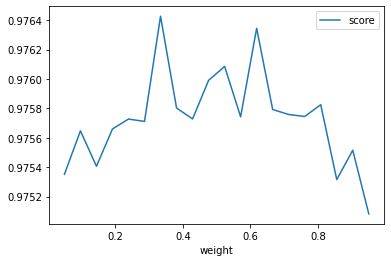

In [0]:
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'weight': weights})

data_out.plot(x='weight')

In [0]:
data_out


,score,weight
0,0.975351,0.050000
1,0.975647,0.097368
2,0.975406,0.144737
3,0.975660,0.192105
4,0.975727,0.239474
5,0.975711,0.286842
6,0.976427,0.334211
7,0.975803,0.381579
8,0.975728,0.428947
9,0.975991,0.476316


In [54]:
# class_weights = grid_result.best_params_
# class_weights

# class_weights = {'class_weight': {0: 0.5710526315789474, 1: 0.42894736842105263}}
# class_weights

class_weights = {'class_weight': {0: 0.618421, 1: 0.381579}}
class_weights


{'class_weight': {0: 0.618421, 1: 0.381579}}

<h2>Cross Validation for the Selected Model</h2>

In [0]:
model = RandomForestClassifier(**class_weights)
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {0: 0.5710526315789474, 1: 0.42894736842105263},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [0]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

# number of features to consider at every split
max_features = ['auto', 'sqrt']

# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]


In [0]:
## Creating the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [0]:
model = RandomForestClassifier(**class_weights)

model_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=kfold, verbose=2, random_state=42, n_jobs=-1, scoring='f1')
model_random.fit(X_train, y_train)


In [0]:
## Best parameters
model_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [0]:
## GridSearch on best range
param_grid = {
    'n_estimators': [700, 800, 900],
    'max_features': ['sqrt'],
    'max_depth': [20, 30],
    'min_samples_split': [10, 12],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [False]
}

In [0]:
model = RandomForestClassifier(**class_weights)

model_grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, verbose=2, n_jobs=-1, scoring='f1')
model_grid.fit(X_train, y_train)


Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 33.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 0.5710526315789474,
                                                            1: 0.42894736842105263},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              m...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                   

In [0]:
model_grid.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 900}

<h2>Train for the Selected Model</h2>

In [55]:
model = RandomForestClassifier(
    bootstrap=True,
    max_depth=30,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=12,
    n_estimators=1800,
    **class_weights
)

rfc_scores = []
score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
rfc_scores.append(score.mean())

print('% Accuracy :', round(score.mean()*100, 4))


% Accuracy : 97.7155


In [56]:
model.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 0.618421, 1: 0.381579}, max_depth=30,
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=1800)

<h2>Predicting and Preparing the Submission</h2>

In [57]:
trip_ids = test.tripid

labels_to_drop = [
    'tripid',
    'pick_lat',
    'pick_lon',
    'drop_lat',
    'drop_lon',
    'pickup_time',
    'drop_time',

    'fare_hour',
    'is_weekend'
    
#     'trip_distance',
#     'fare_to_duration',
#     'trip_duration',
#     'distance_to_duration',
#     'duration_error',
#     'meter_waiting_till_pickup',
#     'additional_fare'
]

test = test.drop(labels=labels_to_drop, axis=1)


In [58]:
predictions = model.predict(test)

output = pd.DataFrame({'tripid': trip_ids, 'prediction': predictions})
output.to_csv('../../submissions/160253h_submission_36.csv', index=False)

# output.to_csv('160253h_submission_36.csv', index=False)
# !cp '160253h_submission_36.csv' "drive/My Drive/ML/submissions/"

print('Completed!')


Completed!


model training.

KNNImputer to impute missing values.

~with cross validation (to tune hiper-parameters).~ [not tuned]

with feature engineering (added 22 new features).

datetime columns have dropped (new features added).

DBCSAN clustering as a features.

[model: Random Forest Classifier]

=====================================

*drop few less important features)

score: 0.97865
